$
\newcommand{\ELBO}{\text{ELBO}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
\newcommand{\ud}{\,\text{d}}
\newcommand{\CN}{\mathcal{N}}
\newcommand{\CB}{\mathcal{B}}
\newcommand{\aux}{\text{aux}}
\newcommand{\do}{do}
\newcommand{\Xmat}{\boldsymbol{X}}
\newcommand{\zv}{\bs{z}}
\newcommand{\xv}{\bs{x}}
\newcommand{\Xv}{\bs{X}}
\newcommand{\Yv}{\bs{Y}}
\newcommand{\BD}{\mathbb{D}}
\newcommand{\KL}{\text{KL}}$

### Balancing Variational Neural Inference Causal Estimation

* Using reformulated ELBO for training
  * $m(\zv) = \EE[Y|\zv]$: expected outcome model
  * $e(\zv) = p(t|\zv)$: propensity score model
  * $\tau(\zv) = \EE[Y(1) - Y(0)|\zv]$: causal effect model

* Learning objective:
  * Robinson residual: $r(\zv) = y - m(\zv) - (t - e(\zv))\times\tau(\zv)$
  * $\ELBO = \log e(\zv) - \rho r^2(\zv) - \BD_{\KL}(q \parallel p) - \lambda \BD_{\KL}(q_0 \parallel q_1)$
    * $\zv \sim q(\zv|\xv)$
    * $\rho$ is the precision parameter
    * $\lambda$ is the balancing regularization

In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf

import pandas as pd
import math

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:

l2_reg = 1e-4
beta = 1.   # ELBO's KL term
gamma = 1.  # PS likelihood
rho = 1     # outcome likelihood
lam = 1     # imbalance parameter

# lr = 1e-3
lr = 1e-4
# lam = 0

ihdp_id = 0
# rho = 10

# NORM = False
NORM = True

l2_reg = 0
# l2_reg = 1e-3

# RDECOMP = False
RDECOMP = True

# Adversarial VAE
# whether to match the aggregated posterior to the prior
# AVB = False
AVB = True  

XONLY = True
XONLY = False

In [3]:
# tf.keras.layers

In [4]:
class flags:
    
    # dim = 2
    
    x_dim = 25
    y_dim = 1
    t_dim = 2
    M = 10
    
    hidden_units = 64
    hidden_size = 2
    
    # hidden_size = 1
    # hidden_units = 32
    
    xi_dim = 100
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    # batch_size = 400
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [5]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [6]:
def softmax(x):
    exp_x = np.exp(x)
    y = exp_x / np.sum(exp_x,axis=1,keepdims=True)
    # y = y / np.sum(y,axis=1,keepdims=True)
    return y

def sample_category_logits(logits):
    pval = softmax(logits)
    n,m = pval.shape
    sampl = np.zeros([n,m])
    for i in range(pval.shape[0]):
        sampl[i,:] = np.random.multinomial(1,pval[i,:])

    return sampl


In [8]:
initializer = tf.contrib.layers.xavier_initializer()

# nonlinearity=tf.nn.elu
nonlinearity=tf.nn.relu

def encoder(input_x,input_y,input_t,name='encoder'):
    '''
    approximate posterior of z given x,y,t
    p(z|x,y,t)
    return mean and var of z
    
    '''
    if input_y is None:
        input_tensor = input_x
    else:
        input_tensor = tf.concat([input_x,input_y,input_t],axis=-1)  # cbind 
    
    hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    # latent_size = 2     # dimension of z
    
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,2*FLAGS.hidden_size,kernel_initializer=initializer,activation=None)
        # o = tf.layers.dense(h2,2*latent_size,activation=None,use_bias=False)
        
    # o is the output of encoder
    # o[:hidden_size]: mean(z)
    # o[hidden_size:]: log var(z)
    
#     mean = o[:, :FLAGS.hidden_size]
#     std = o[:, FLAGS.hidden_size:]
#     o = tf.concat([mean,tf.constant(-4+np.zeros([FLAGS.batch_size,FLAGS.hidden_size]),tf.float32)],axis=1)
    
    # stddev = tf.sqrt(tf.exp(latent_code[:, FLAGS.hidden_size:]))
    
    return o

def s_encoder(input_x,input_y,input_t,name='encoder'):
    '''
    stocahstic encoder
    approximate posterior of z given x,y,t
    p(z|x,y,t)
    
    '''
    
    xi = tf.random.uniform([FLAGS.batch_size,FLAGS.xi_dim], minval=-1,maxval=1)
    
    if input_y is None:
        input_tensor = tf.concat([input_x,xi],axis=-1)
    else:
        input_tensor = tf.concat([input_x,input_y,input_t,xi],axis=-1)  # cbind 
    
    hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    # latent_size = 2     # dimension of z
    
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,FLAGS.hidden_size,kernel_initializer=initializer,activation=None)
        
    return o

def generator(x, name='generator'):
    
    '''
    Conditional generator for q(z|x)
    '''
    
    hidden_units = FLAGS.hidden_units 
    
    xi = tf.random.uniform([FLAGS.batch_size,FLAGS.xi_dim], minval=-1,maxval=1)
    
    input_tensor = tf.concat([x,xi],axis=-1)
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,FLAGS.hidden_size,kernel_initializer=initializer,activation=None)
    
    return o
    
def critic(z,x,name):
    
    hidden_units = FLAGS.hidden_units    # size of hidden units in a layer
    
    if x is None:
        input_tensor = z;
    else:
        input_tensor = tf.concat([x,z],axis=-1)
    
    with tf.variable_scope('critic-%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # o = tf.layers.dense(h2,1,activation=None)
        o = tf.layers.dense(h2,1,kernel_initializer=initializer,activation=tf.nn.tanh)
        o *= 5
        
    return o;

def encoder2(input_x,input_y,input_t,name='encoder',nonlinearity=tf.nn.elu):
    '''
    approximate posterior of z given x,y,t
    p(z|x,y,t)
    return mean and var of z
    
    '''
    
    if input_y is None or input_t is None:
        input_tensor = input_x
    else:
        input_tensor = tf.concat([input_x,input_y,input_t],axis=-1)  # cbind 
    
    hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    # latent_size = 2     # dimension of z
    
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,2*FLAGS.hidden_size,kernel_initializer=initializer,activation=None)
        # o = tf.layers.dense(h2,2*latent_size,activation=None,use_bias=False)
        
    # o is the output of encoder
    # o[:hidden_size]: mean(z)
    # o[hidden_size:]: log var(z)
    
    return o,h2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
def simple_mlp(x,out_dim,name):
    
    hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    
    input_tensor = x
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,out_dim,kernel_initializer=initializer,activation=None)
        
    return o;

In [10]:
def qt(input_x,nonlinearity=tf.nn.elu):
    '''
    Auxiliary treatment predictor
    q(t|x)

    return: logits
    '''

    input_tensor = input_x

    hidden_units = 64   # size of hidden units in a layer
    # latent_size = 2     # dimension of z

    with tf.variable_scope('qt',reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,activation=nonlinearity)
        o = tf.layers.dense(h2,2,activation=None)

    return o

def qy(input_x,input_t,nonlinearity=tf.nn.elu):
    '''
    Auxiliary outcome predictor
    q(y|x,t)

    return: logits
    '''

    input_tensor = tf.concat([input_x,input_t],axis=-1)

    hidden_units = 64   # size of hidden units in a layer
    # latent_size = 2     # dimension of z

    with tf.variable_scope('qy',reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,activation=nonlinearity)
        o = tf.layers.dense(h2,FLAGS.M,activation=None)

    return o

#### Result evaluation

In [11]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

#### VAE utilities

In [12]:
def get_kl_cost(mean,stddev, epsilon=1e-8):                      
    '''
    Compute the KL-divergence btw q(z|x) and p(z)
    
    KL(q||p)
    
    '''
    
    return tf.reduce_sum(0.5 * (tf.square(mean) + tf.square(stddev) -
                                2.0 * tf.log(stddev + epsilon) - 1.0), axis=1)     

### Evaluation functions

In [13]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname,end=': ')
    print(x_shape)

def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size, n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [14]:
def ymul2y(yy,Yq):
    
    m_samples = yy.shape[0]
    y = np.zeros([m_samples,1])
    
    for i in range(m_samples):
        j = np.where(yy[i,:])[0][0]
        y[i] = Yq[j] + np.random.rand()*(Yq[j+1]-Yq[j]) 
        
    return y

def estimate_causal_effect(xx,n_runs=1,progress=False):
    
    m_samples = xx.shape[0]
    tau_sum = np.zeros([m_samples,1])
    
    for i in range(n_runs):
        
        if progress:
            print('Computing %d / %d ...' % (i+1, n_runs))
        
        # zz = tf_eval(sampled_z_x, m_samples, {input_x: xx})
        tau_val = tf_eval(tau_z, m_samples, {sampled_z: zz}) # this line
        # tau_val = tf_eval(tau_z_x, m_samples, {input_x: xx})
        
        tau_sum += tau_val
        
    return tau_sum/n_runs

In [15]:
def estimate_ps(xx,n_runs=1,progress=False):
    
    '''
    xx: confounder proxies
    to: observed treatment
    '''
    
    m_samples = xx.shape[0]
    # tau_sum = np.zeros([m_samples,1])
    
    # print(m_samples)
    
    yy_mdl = np.zeros([m_samples,n_runs])
    
    for i in range(n_runs):
        
        if progress:
            print('Computing %d / %d ...' % (i+1, n_runs))
        
#         res = tf_eval_list([tau_z_x, m_z_x, e_z_x], m_samples, {input_x: xx})
#         m_val = res[m_z_x]
#         tau_val = res[tau_z_x]
#         e_val = res[e_z_x]
        e_val = tf_eval(e_z_x, m_samples, {input_x: xx})
        yy_mdl[:,i] = e_val.reshape([-1,])
        
    return yy_mdl

def eval_nll_ps(X_val,T_val,n_runs=1):
    ps_val = np.mean(estimate_ps(X_val,n_runs=100),axis=1)
    loglik_ps_val = np.log(T_val[:,0]*(1-ps_val)+T_val[:,1]*ps_val)
    ps_nll_val = -np.mean(loglik_ps_val)
    return ps_nll_val

def eval_nll_ps_x(X_val,T_val):
    
    m_samples = X_val.shape[0]
    ps_val = tf_eval(e_x, m_samples, {input_x: X_val}).reshape([-1,])
    loglik_ps_val = np.log(T_val[:,0]*(1-ps_val)+T_val[:,1]*ps_val)
    ps_nll_val = -np.mean(loglik_ps_val)
    
    return ps_nll_val

### Load data

In [16]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

In [17]:
# Loading normalized IHDP example
data = np.load('../ihdp_example.npy',allow_pickle=True).item()
X = data['X'] # Confounder proxiess
Y = data['Y'] # Factual outcomes
T = data['T'] # Treatment
Tau = data['Tau']  # Ground truth ITE

n_samples = X.shape[0]

In [21]:
# normalization

y_std = 1.

if NORM:
    y_m = np.mean(Y)
    y_std = np.std(Y)

    Y = (Y-y_m)/y_std

    Tau = Tau/y_std

#### \# Preprocessing

In [23]:
# Break Y into M bins

M = FLAGS.M
q = np.linspace(0,1,M+1)

Yq = np.quantile(Y,q)

Yqq = Yq.copy()
Yqq[0] = -1e10
Yqq[-1] = 1e10

n_samples = Y.shape[0]
Ymul = np.zeros([n_samples,M])

for i in range(n_samples):
    for j in range(M):
        if Y[i]>= Yqq[j] and Y[i]<Yqq[j+1]:
            Ymul[i,j] = 1
            break

#### Cross-validation splitting

In [25]:
prob_train = 0.7

n_train_samples = int(np.ceil(prob_train*n_samples))

shuff_idx = np.array(range(n_samples))
# Shuffle the indices
# np.random.shuffle(shuff_idx)

train_idx = shuff_idx[:n_train_samples]
val_idx = shuff_idx[n_train_samples:]

In [26]:
X_val = X[val_idx]
Y_val = Y[val_idx]
T_val = T[val_idx]

X = X[train_idx]
Y = Y[train_idx]
T = T[train_idx]
Ymul = Ymul[train_idx]

n_samples = n_train_samples

In [27]:
Tau_val = Tau[val_idx]
Tau = Tau[train_idx]

In [28]:
t1_ind = T[:,1]==1   # find which column has the treatment == 1
t0_ind = T[:,0]==1 

n0 = np.sum(t0_ind)
n1 = np.sum(t1_ind)

X0 = X[t0_ind]
X1 = X[t1_ind]

Y0 = Y[t0_ind]
Y1 = Y[t1_ind]

In [29]:
def gauss_sampler(latent_code=None):
    epsilon = tf.random_normal([FLAGS.batch_size, FLAGS.hidden_size])
    
    # input_tensor = tf.cast(input_tensor,tf.float32)
    # input_t = tf.cast(input_t, tf.float32)
    
    # If input is none, sample z from prior
    # input_tensor[:half]: mean, input_tensor[half:]: log var,
    if latent_code is None:
        mean = None
        stddev = None
        input_sample = epsilon
    else:
        mean = latent_code[:, :FLAGS.hidden_size]
        stddev = tf.sqrt(tf.exp(latent_code[:, FLAGS.hidden_size:]))
        input_sample = mean + epsilon * stddev
        
    return input_sample

### Model specification

#### \# Encoder

In [30]:
input_x = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_t = tf.placeholder(tf.int32, shape=[FLAGS.batch_size, FLAGS.t_dim])
input_y = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])
input_ymul = tf.placeholder(tf.int32, shape=[FLAGS.batch_size, FLAGS.M])

_,phi_x = encoder2(input_x,None,None,'encoderX')

if AVB:
    if XONLY: sampled_z = s_encoder(phi_x, None, None)  # q(z|x)
    else: sampled_z = s_encoder(phi_x, input_y, tf.cast(input_t,tf.float32))  # q(z|x)
    
    nu_q_vec = critic(sampled_z, None, 'ELBO')
    nu_p_vec = critic(tf.random.normal([FLAGS.batch_size, FLAGS.hidden_size]), None, 'ELBO')

    loss_kl = tf.reduce_mean(nu_q_vec) - tf.reduce_mean(tf.exp(nu_p_vec))
    
else:
    if XONLY: latent_code = encoder(phi_x, None, None)  # q(z|x)
    else: latent_code = encoder(phi_x, input_y, tf.cast(input_t,tf.float32))  # q(z|x)
    sampled_z = gauss_sampler(latent_code)
    
    mean = latent_code[:,:FLAGS.hidden_size]
    stddev = tf.sqrt(tf.exp(latent_code[:,FLAGS.hidden_size:]))
    loss_kl_vec = get_kl_cost(mean,stddev)
    loss_kl = tf.reduce_mean(loss_kl_vec)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


#### \# propensity model absed on $x$

In [32]:
logit_t_x = simple_mlp(input_x, 2, 'ps_x') # propensity score
e_x = tf.reshape(tf.nn.softmax(logit_t_x)[:,1],[-1,1])

loss_e_x_vec = tf.nn.softmax_cross_entropy_with_logits(labels=input_t, logits=logit_t_x)
loss_e_x = tf.reduce_mean(loss_e_x_vec)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### \# Robinson residual

In [33]:
if RDECOMP:

    m_z = simple_mlp(sampled_z, 1, 'm') # expected outcome 
    tau_z = simple_mlp(sampled_z, 1, 'tau') # causal effect
    logit_t_z = simple_mlp(sampled_z, 2, 'ps') # propensity score
    e_z = tf.reshape(tf.nn.softmax(logit_t_z)[:,1],[-1,1])

    loss_e_vec = tf.nn.softmax_cross_entropy_with_logits(labels=input_t, logits=logit_t_z)
    loss_e = tf.reduce_mean(loss_e_vec)

    # Continuous outcome
    input_t_bin = tf.reshape(tf.cast(input_t[:,1],dtype=tf.float32),[-1,1])
    robinson_res = (input_y - m_z) - (tf.cast(input_t_bin, dtype=tf.float32) - e_z) * tau_z

    loss_r = tf.reduce_mean(tf.square(robinson_res))

    loss_m = tf.reduce_mean(tf.square(input_y - m_z))

#### \# Regular decomposition

In [35]:
if RDECOMP is False:


#     # S-learner
#     input_zt = tf.concat([sampled_z,tf.cast(input_t,tf.float32)],axis=1)
#     mu_t_z = simple_mlp(input_zt, 1, 'tau')
#     t0_np = np.zeros([FLAGS.batch_size,2],dtype=np.int32); t0_np[:,0] = 1
#     t1_np = np.zeros([FLAGS.batch_size,2],dtype=np.int32); t1_np[:,1] = 1
#     t0_tf = tf.constant(t0_np,tf.float32)
#     t1_tf = tf.constant(t1_np,tf.float32)
#     input_zt0 = tf.concat([sampled_z,t0_tf],axis=1)
#     input_zt1 = tf.concat([sampled_z,t1_tf],axis=1)
#     mu_0_z = simple_mlp(input_zt0, 1, 'tau')
#     mu_1_z = simple_mlp(input_zt1, 1, 'tau')
    
    
    # T-learner
    mu_0_z = simple_mlp(sampled_z, 1, 'tau0')
    mu_1_z = simple_mlp(sampled_z, 1, 'tau1')
    input_t_bin = tf.reshape(tf.cast(input_t[:,1],dtype=tf.float32),[-1,1])
    mu_t_z = input_t_bin*mu_1_z + (1-input_t_bin)*mu_0_z
    
    
    tau_z = mu_1_z - mu_0_z # causal effect

    logit_t_z = simple_mlp(sampled_z, 2, 'ps') # propensity score
    e_z = tf.reshape(tf.nn.softmax(logit_t_z)[:,1],[-1,1])

    loss_e_vec = tf.nn.softmax_cross_entropy_with_logits(labels=input_t, logits=logit_t_z)
    loss_e = tf.reduce_mean(loss_e_vec)

    robinson_res = input_y - mu_t_z

    loss_r = tf.reduce_mean(tf.square(robinson_res))


#### \# Balancing KL

In [37]:
input_x_t0 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_x_t1 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_y_t0 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])
input_y_t1 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])

t0_np = np.zeros([FLAGS.batch_size,2],dtype=np.float32); t0_np[:,0] = 1
t1_np = np.zeros([FLAGS.batch_size,2],dtype=np.float32); t1_np[:,1] = 1
t0_tf = tf.constant(t0_np)
t1_tf = tf.constant(t1_np)

_,phi_x_t0 = encoder2(input_x_t0,None,None,'encoderX')
_,phi_x_t1 = encoder2(input_x_t1,None,None,'encoderX')


if AVB:
    if XONLY:
        sampled_z0 = s_encoder(phi_x_t0, None, None)
        sampled_z1 = s_encoder(phi_x_t1, None, None)
    else:
        sampled_z0 = s_encoder(phi_x_t0, input_y_t0, t0_tf)
        sampled_z1 = s_encoder(phi_x_t1, input_y_t1, t1_tf)
else:
    if XONLY:
        latent_code_t0 = encoder(phi_x_t0, None, None)
        latent_code_t1 = encoder(phi_x_t1, None, None)
    else:
        latent_code_t0 = encoder(phi_x_t0, input_y_t0, t0_tf)
        latent_code_t1 = encoder(phi_x_t1, input_y_t1, t1_tf)
    sampled_z0 = gauss_sampler(latent_code_t0)
    sampled_z1 = gauss_sampler(latent_code_t1)


nu0_vec = critic(sampled_z0, None, 'KL')
nu1_vec = critic(sampled_z1, None, 'KL')

loss_fkl = tf.reduce_mean(nu0_vec) - tf.reduce_mean(tf.exp(nu1_vec))

In [38]:
# t1_np

#### \# Auxiliary models

In [39]:
sampled_z_x = generator(input_x)

if RDECOMP:
    tau_z_x = simple_mlp(sampled_z_x, 1, 'tau') # causal effect
    m_z_x = simple_mlp(sampled_z_x, 1, 'm') # expected outcome 
else:
    
#     # S-learner
#     input_zt0_x = tf.concat([sampled_z_x,t0_tf],axis=1)
#     input_zt1_x = tf.concat([sampled_z_x,t1_tf],axis=1)
#     mu_0_z_x = simple_mlp(input_zt0_x, 1, 'tau')
#     mu_1_z_x = simple_mlp(input_zt1_x, 1, 'tau')
#     tau_z_x = mu_1_z_x - mu_0_z_x # causal effect

    mu_0_z_x = simple_mlp(sampled_z_x, 1, 'tau0')
    mu_1_z_x = simple_mlp(sampled_z_x, 1, 'tau1')
    tau_z_x = mu_1_z_x - mu_0_z_x

logit_t_z_x = simple_mlp(sampled_z_x, 2, 'ps') 
e_z_x = tf.reshape(tf.nn.softmax(logit_t_z_x)[:,1],[-1,1]) # propensity score


nu0x_vec = critic(sampled_z, input_x, 'gen')
nu1x_vec = critic(sampled_z_x, input_x, 'gen')

loss_xkl = tf.reduce_mean(nu0x_vec) - tf.reduce_mean(tf.exp(nu1x_vec))

In [40]:

feature_x = phi_x


logit_t_x = qt(feature_x)
loglik_qt = tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_t, logits=logit_t_x)
loss_qt = tf.reduce_mean(loglik_qt)
# continuous outcome
# binned multinomial regression ^_^


logit_y_xt = qy(feature_x,tf.cast(input_t,tf.float32))
loglik_qy = tf.nn.softmax_cross_entropy_with_logits(labels=input_ymul, logits=logit_y_xt)
loss_qy = tf.reduce_mean(loglik_qy)

In [41]:
LAM = tf.placeholder(tf.float32)
RHO = tf.placeholder(tf.float32)

loss_elbo = RHO*loss_r + gamma*loss_e + beta*loss_kl
loss_bnice = loss_elbo + LAM*loss_fkl

### Optimizer specifications

In [42]:
m_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('m')]
tau_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('tau')]
ps_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('ps')]

# critic_vars = [v for v in tf.get_collection(
#     tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('critic-KL')]
critic_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('critic')]
encoder_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('encoder')]
gen_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('generator')]

# elbo_vars = m_vars + tau_vars + ps_vars
elbo_vars = m_vars + tau_vars + ps_vars + encoder_vars

qt_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('qt')]
qy_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('qy')]

In [43]:
if l2_reg>0:

    l2_loss = 0.
    var_list = [elbo_vars, critic_vars, gen_vars]
    for vv in var_list:
        for v in vv:
            if ('bias' in v.name) is False:
                l2_loss += tf.reduce_sum(tf.square(v))



    l2_loss *= l2_reg

    loss_fkl += l2_loss
    loss_xkl += l2_loss
    loss_bnice += l2_loss


loss_bnice += loss_e_x

In [44]:
learning_rate = tf.placeholder(tf.float32)

elbo_lr = .1*learning_rate
critic_lr = learning_rate

Optimizer = tf.train.AdamOptimizer
# Optimizer = tf.train.RMSPropOptimizer


train_elbo = Optimizer(learning_rate).minimize(loss_elbo,var_list=elbo_vars)   # for encoder/decoder
# train_critic = tf.train.AdamOptimizer(critic_lr).minimize(-loss_fkl, var_list=critic_vars)
if AVB:
    train_critic = Optimizer(critic_lr).minimize(-loss_fkl-loss_xkl-loss_kl, var_list=critic_vars)
else:
    train_critic = Optimizer(critic_lr).minimize(-loss_fkl-loss_xkl, var_list=critic_vars)

train_bnice = Optimizer(learning_rate).minimize(loss_bnice, var_list=elbo_vars)

train_aux_qt = Optimizer(learning_rate).minimize(loss_qt, var_list=qt_vars)   # for q(t|x)
train_aux_qy = Optimizer(learning_rate).minimize(loss_qy, var_list=qy_vars)   # for q(y|t,x)

train_aux_gen = Optimizer(learning_rate).minimize(loss_xkl, var_list=gen_vars)

In [ ]:
# critic_vars

### Model initialization

In [45]:
# Initialization

initializer = tf.global_variables_initializer()
sess.run(initializer)

### Training

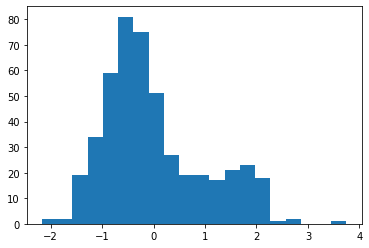

In [46]:
_ = plt.hist(Y, bins=20)

[1, 0.7112258899211884, -0.46163112834095954, 4.002407550811768]
PEHE=1.41, CORR=0.29
[2, -0.7041922469139099, 0.016403754055499986, 3.6349048614501953]
PEHE=0.98, CORR=0.42
[3, -1.135898557126522, 0.014679739713668871, 3.4901602268218994]
PEHE=0.95, CORR=0.71
[4, -1.328780823945999, 0.03495693105459208, 3.6245474815368652]
PEHE=0.93, CORR=0.80
[5, -1.4135482244491577, 0.10398260891437527, 3.625148057937622]
PEHE=1.06, CORR=0.81
[6, -1.4528890280723572, 0.13812440231442447, 3.449954032897949]
PEHE=1.13, CORR=0.81
[7, -1.4756464225053787, 0.18926314580440518, 3.6054766178131104]
PEHE=0.88, CORR=0.72
[8, -1.4900938521623612, 0.20769159895181655, 3.5240437984466553]
PEHE=0.99, CORR=0.50
[9, -1.492479257583618, 0.24155121585726735, 3.5799155235290527]
PEHE=1.09, CORR=0.73
[10, -1.5020298686027527, 0.23873753201961523, 3.634438991546631]
PEHE=1.05, CORR=0.66


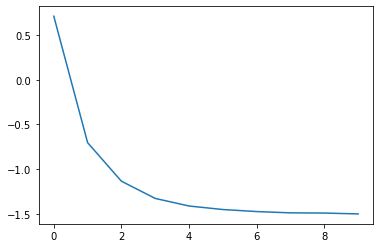

In [47]:
# Training for encoder/deconder
# lam = 0.01

max_epoch = 10
updates_per_epoch = 1000

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    loss_xkl_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        # n_samples
        ind = np.random.choice(n_samples,FLAGS.batch_size)
        # ind
        feed_dict = {learning_rate:lr, RHO:rho, LAM:lam}
        feed_dict[input_x] = X[ind]
        feed_dict[input_y] = Y[ind]
        feed_dict[input_t] = T[ind]
        
        feed_dict[input_ymul] = Ymul[ind]
        
        ind = np.random.choice(n0,FLAGS.batch_size)
        feed_dict[input_x_t0] = X0[ind]
        feed_dict[input_y_t0] = Y0[ind]
        ind = np.random.choice(n1,FLAGS.batch_size)
        feed_dict[input_x_t1] = X1[ind]
        feed_dict[input_y_t1] = Y1[ind]
        
#         _,_,loss_qt_val,loss_qy_val = sess.run([train_aux_qt, train_aux_qy, loss_qt, loss_qy], feed_dict)
#         loss_record[step] = loss_qt_val + loss_qy_val
        
#         _,loss_elbo_val = sess.run([train_elbo, loss_elbo], feed_dict)
#         loss_record[step] = loss_elbo_val
        
#         _,_,loss_bnice_val = sess.run([train_critic, train_bnice, loss_bnice], feed_dict)
#         loss_record[step] = loss_bnice_val

#         _,_,loss_xkl_val,loss_bnice_val = sess.run([train_critic, train_aux_gen, \
#                                         loss_xkl,loss_bnice], feed_dict)


        _,_,_,loss_xkl_val,loss_bnice_val = sess.run([train_critic, train_bnice, train_aux_gen, \
                                        loss_xkl,loss_bnice], feed_dict)
    

        loss_record[step] = loss_bnice_val
        loss_xkl_record[step] = loss_xkl_val
    
    t1 = time()
    
    klm = np.mean(loss_xkl_record)+1
    print([epoch_id+1,np.mean(loss_record),klm,t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
    
    tau_hat = estimate_causal_effect(X, n_runs=128, progress=False)

    pehe_bnice = eval_pehe(tau_hat, Tau)*y_std
    corr_bnice = np.corrcoef(tau_hat.reshape([-1,]),Tau.reshape([-1,]))[0,1]
    
    print('PEHE=%.2f, CORR=%.2f' % (pehe_bnice, corr_bnice))
    
_ = plt.plot(epoch_record)